In [1]:
!{__import__('sys').executable} -m pip install --quiet -r requirements.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

#import matplotlib.pyplot as plt

In [3]:
session_storage = 'downloads'

import os
os.makedirs(session_storage, exist_ok=True)

In [4]:
import fsspec

fs_dataset = fsspec.filesystem(
    'simplecache', 
    target_protocol='https', 
    cache_storage=session_storage
)

In [5]:
import pandas as pd
'''
import swifter
swifter.set_defaults(
    npartitions=None,
    dask_thres=1,
    scheduler='processes',
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=False
)
'''

import sklearn as skl
import sklearn.base
import sklearn.compose
#import sklearn.ensemble
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.svm

import xgboost

import numpy as np

In [6]:
import sklearnex
sklearnex.patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Dataset

In [7]:
# TODO

dataset_lyrics = None
with fs_dataset.open('https://github.com/cse158-fa22-team-pushystrokers/datasets/raw/main/dataset-lyrics.csv.gz') as f:
    dataset_lyrics = (
        pd.read_csv(
            f, 
            compression='gzip'
        ).astype({
            'artist': 'category',
            'year': 'datetime64',
            'genre': 'category'
        }, copy=False)
    )

In [8]:
dataset_lyrics

,song,year,artist,genre,lyrics
0,ego-remix,2009-01-01,beyonce-knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut..."
1,then-tell-me,2009-01-01,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem..."
2,honesty,2009-01-01,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,you-are-my-rock,2009-01-01,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,black-culture,2009-01-01,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...
235989,who-am-i-drinking-tonight,2012-01-01,edens-edge,Country,"I gotta say Boy, after only just a couple of d..."
235990,liar,2012-01-01,edens-edge,Country,I helped you find her diamond ring You made me...
235991,last-supper,2012-01-01,edens-edge,Country,Look at the couple in the corner booth Looks a...
235992,christ-alone-live-in-studio,2012-01-01,edens-edge,Country,When I fly off this mortal earth And I'm measu...


In [9]:
dataset_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235994 entries, 0 to 235993
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   song    235993 non-null  object        
 1   year    235994 non-null  datetime64[ns]
 2   artist  235994 non-null  category      
 3   genre   235994 non-null  category      
 4   lyrics  235994 non-null  object        
dtypes: category(2), datetime64[ns](1), object(2)
memory usage: 6.7+ MB


In [10]:
# TODO
# example
dataset_lyrics[dataset_lyrics['artist'] == 'florida-georgia-line']

,song,year,artist,genre,lyrics
114040,take-it-out-on-me,2013-01-01,florida-georgia-line,Country,What'd he do this time? Did he break your hear...
114041,hands-on-you,2013-01-01,florida-georgia-line,Country,"When I get my hands on you, I'm gonna do every..."
114042,headphones,2013-01-01,florida-georgia-line,Country,You were a whip around town Tinted windows dow...
114043,people-back-home,2013-01-01,florida-georgia-line,Country,This is for my people back home We're lighting...
114044,cruise-remix,2013-01-01,florida-georgia-line,Country,Baby you a song You make me wanna roll my wind...
114045,this-is-how-we-roll,2013-01-01,florida-georgia-line,Country,"The mix tape's got a little Hank, little Drake..."
114046,tell-me-how-you-like-it,2012-01-01,florida-georgia-line,Country,Do you like it when the meter's jumpin'? You l...
114047,party-people,2012-01-01,florida-georgia-line,Country,Hey hey hey hey Where my party people Oh oh oh...
114048,dayum-baby,2012-01-01,florida-georgia-line,Country,"Hey baby, listen you got me twistin', watching..."
114049,round-here,2012-01-01,florida-georgia-line,Country,"A hammer and a nail, stacking them bails I'm d..."


## EDA

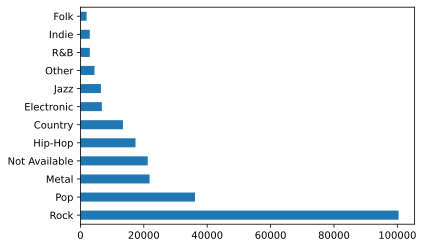

In [11]:
_ = dataset_lyrics['genre'].value_counts().plot(kind='barh')

In [12]:
dataset_lyrics = dataset_lyrics[dataset_lyrics['genre'] != 'Not Available']

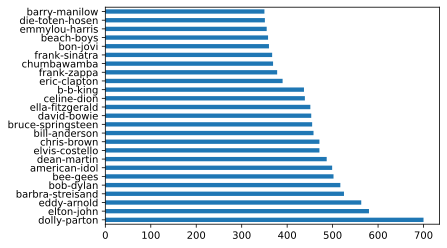

In [13]:
_ = dataset_lyrics['artist'].value_counts().head(25).plot(kind='barh')

## Predictive Task

## Model

### Baseline Model

In [14]:
def make_dataframe_transformer(cls):
    class cls_(cls):
        def transform(self, *args, **kwargs):
            res = super().transform(*args, **kwargs)
            if isinstance(res, pd.Series):
                return res.to_frame()
            return pd.DataFrame(res)
    return cls_

#### Category Transformer

In [54]:
cat_transformer_baseline = (
    skl.preprocessing.OneHotEncoder(
        handle_unknown='ignore'
    )
)

#### Text Transformer

In [55]:
import joblib

class BaseParallelTransformer(skl.base.TransformerMixin):
    def __init__(self, n_jobs, func, kwargs_func={}):
        super().__init__()
        self.n_jobs = n_jobs
        self.func = func
        self.kwargs_func = kwargs_func

    def fit(self, _X, _y=None):
        return self

    def transform(self, Xs, _y=None):
        return joblib.Parallel(n_jobs=self.n_jobs)(
            joblib.delayed(self.func)(X, **self.kwargs_func) 
                for X in Xs
        )

In [56]:
import nltk
nltk.download('omw-1.4')

class WordTokenizer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        super().__init__(
            n_jobs=n_jobs,
            func=nltk.word_tokenize,
            kwargs_func=kwargs
        )

class WordNetLemmatizer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        base = nltk.stem.WordNetLemmatizer()
        super().__init__(
            n_jobs=n_jobs,
            func=lambda tokens: list(map(base.lemmatize, tokens)),
            kwargs_func=kwargs
        )

class SnowballStemmer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        base = nltk.stem.SnowballStemmer(**kwargs)
        super().__init__(
            n_jobs=n_jobs,
            func=lambda tokens: list(map(base.stem, tokens)),
            kwargs_func={}
        )

[nltk_data] Downloading package omw-1.4 to /home/r8chen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [57]:
import string

tokens_blocked = (
    set(nltk.corpus.stopwords.words('english'))
        | set(string.punctuation)
)
tokenizer_baseline = skl.pipeline.Pipeline([
    ('filter_cap',
        BaseParallelTransformer(
            n_jobs=-1, 
            func=lambda text: text.lower() 
        )
    ),
    ('tokenizer', WordTokenizer(n_jobs=-1, language='english')),
    ('filter_tokens', 
        BaseParallelTransformer(
            n_jobs=-1, 
            func=lambda tokens: filter(
                lambda token: token not in tokens_blocked,
                tokens
            )
        )
    ),
    ('lemmatizer', WordNetLemmatizer(n_jobs=-1)),
    ('stemmer', SnowballStemmer(n_jobs=-1, language='english'))
])

In [58]:
text_transformer_baseline = skl.pipeline.Pipeline([
    *tokenizer_baseline.steps,
    ('token_count_vec', 
        skl.feature_extraction.text.CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=None,
            lowercase=False    
        )
    ),
    ('token_freq_vec', 
        skl.feature_extraction.text.TfidfTransformer()
    ),
])

#### Pipeline: Model

In [59]:
model_cv_baseline = skl.model_selection.GridSearchCV(
    skl.linear_model.LogisticRegression(
        max_iter=1000
    ),
    param_grid={
        'class_weight': ['balanced'],
        'solver': ['saga'],
        'C': np.logspace(start=-1, stop=2, num=3),
    }, 
    cv=skl.model_selection.RepeatedStratifiedKFold(n_splits=2, n_repeats=1),
    scoring='balanced_accuracy',
    #n_jobs=-1,
    verbose=3
)

In [60]:
model_cv_gboost = skl.model_selection.GridSearchCV(
    xgboost.XGBClassifier(
        booster='gbtree',
        objective='multi:softmax',
        tree_method='gpu_hist', 
        predictor='gpu_predictor',
        sampling_method='gradient_based',
        enable_categorical=True,
        n_jobs=-1
    ),
    param_grid={
        'learning_rate': [.1, .005],
        'n_estimators': [200],
        'max_depth': [30],
        'subsample': [.75],

        #'gamma': [.1],
        #'reg_alpha': [.1],
        #'reg_lambda': [.1]
    },
    cv=skl.model_selection.RepeatedStratifiedKFold(n_splits=2, n_repeats=1),
    scoring='balanced_accuracy',
    #n_jobs=-1,
    verbose=3
)

####

In [63]:
predictor_baseline = skl.pipeline.Pipeline([
    ('feature_sel', skl.compose.ColumnTransformer([
        ('cat', cat_transformer_baseline, ['artist']),
        ('text', text_transformer_baseline, 'lyrics')
    ])),#, n_jobs=-1)),
    #('scaler', skl.preprocessing.StandardScaler()),
    ('classifier_cv', model_cv_baseline)
    #('classifier_cv', model_cv_gboost)
])

df_lyrics = dataset_lyrics#.sample(20000)
_ = predictor_baseline.fit(
    df_lyrics[['artist', 'lyrics']],
    df_lyrics['genre']
)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/2] END C=0.1, class_weight=balanced, solver=saga;, score=0.875 total time=11.4min


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/2] END C=0.1, class_weight=balanced, solver=saga;, score=0.878 total time=11.4min
